In [1]:
!pip install pandas numpy requests scikit-learn scipy arch matplotlib statsmodels torch eod

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 111.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu

In [2]:
import pandas as pd
import numpy as np
import requests
import torch
from scipy.stats import genpareto, kurtosis
from sklearn.linear_model import LinearRegression
from arch import arch_model
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def hurst_exponent(ts):
    lags = range(2, min(len(ts)//2, 20))
    tau = [np.sqrt(np.std(ts[lag:] - ts[:-lag])) for lag in lags]
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    return max(poly[0] * 2.0, 0)

def quantify_queues_adaptive(data, window_homeo=30, window_fb=5):
    m, s = data['close'].mean(), data['close'].std()
    rs = data['close'].rolling(window_homeo).std()
    rm = data['close'].rolling(window_homeo).mean()
    homeo = (rs / rm).mean()
    r = data['close'].pct_change().dropna()
    fb_p = r.gt(0).rolling(window_fb).mean().mean()
    fb_m = r.lt(0).rolling(window_fb).mean().mean()
    feedback = fb_p - fb_m
    k_up, k_lo = homeo + feedback, homeo - feedback
    up, lo = m + k_up * s, m - k_lo * s
    in_up = data['close'] > up
    in_lo = data['close'] < lo
    return {
        'prob_upper':        in_up.mean() * 100,
        'prob_lower':        in_lo.mean() * 100,
        'mean_upper_excess': (data['close'][in_up] - up).mean() if in_up.any() else 0,
        'max_upper_excess':  (data['close'][in_up] - up).max()  if in_up.any() else 0,
        'mean_lower_excess': (lo - data['close'][in_lo]).mean() if in_lo.any() else 0,
        'max_lower_excess':  (lo - data['close'][in_lo]).max()  if in_lo.any() else 0,
        'homeostasis_coef':  homeo,
        'feedback_coef':     feedback
    }

def calculate_asymmetry_adaptive(data, window_homeo=30, window_fb=5):
    m, s = data['close'].mean(), data['close'].std()
    rs = data['close'].rolling(window_homeo).std()
    rm = data['close'].rolling(window_homeo).mean()
    homeo = (rs / rm).mean()
    r = data['close'].pct_change().dropna()
    fb_p = r.gt(0).rolling(window_fb).mean().mean()
    fb_m = r.lt(0).rolling(window_fb).mean().mean()
    feedback = fb_p - fb_m
    k_up, k_lo = homeo + feedback, homeo - feedback
    up, lo = m + k_up * s, m - k_lo * s
    above = data['close'][data['close'] > up]
    below = data['close'][data['close'] < lo]
    if above.empty or below.empty:
        return 0.0
    return (above - up).mean() - (lo - below).mean()

def analyze_extreme_values(data, threshold_quantile=0.95):
    thresh = data['close'].quantile(threshold_quantile)
    exc = data['close'][data['close'] > thresh] - thresh
    if len(exc) < 2:
        return (np.nan, np.nan, np.nan), thresh
    return genpareto.fit(exc), thresh

def calculate_risk_metrics(data, alpha=0.05):
    r = data['close'].pct_change().dropna()
    if r.empty:
        return np.nan, np.nan
    var = np.percentile(r, alpha * 100)
    es  = r[r <= var].mean()
    return var, es

class SystemicAnalyzer:
    def __init__(self, data):
        self.data = data.copy()

    def ashby_homeostasis(self, window=30):
        std  = self.data['close'].rolling(window).std()
        mean = self.data['close'].rolling(window).mean()
        return (std / mean).mean()

    def bateson_feedback(self):
        r = self.data['close'].pct_change().dropna()
        return r.gt(0).rolling(5).mean().mean() - r.lt(0).rolling(5).mean().mean()

    def requisite_variety(self, max_regimes=6):
        diff = self.data['close'].diff().dropna()
        norm = (diff - diff.mean()) / diff.std()
        best = {'aic': (np.inf, None), 'bic': (np.inf, None)}
        for k in range(2, max_regimes+1):
            try:
                res = MarkovRegression(norm, k_regimes=k).fit(disp=False)
                aic, bic = res.aic, res.bic
                if aic < best['aic'][0]:
                    best['aic'] = (aic, res)
                if bic < best['bic'][0]:
                    best['bic'] = (bic, res)
            except:
                continue
        out = {}
        for crit in ('aic','bic'):
            res = best[crit][1]
            p   = res.smoothed_marginal_probabilities.mean(axis=0)
            out[f'variety_{crit}'] = -(p * np.log2(p)).sum()
        return out

    def fractal_memory(self, p=1, q=1, min_data_points=252):
        r = self.data['close'].pct_change().dropna() * 100
        if len(r) < min_data_points:
            return hurst_exponent(r.values)
        try:
            r_t = np.sign(r) * np.sqrt(np.abs(r))
            fit = arch_model(r_t, vol='FIGARCH', p=p, q=q, dist='skewt')\
                      .fit(disp='off', update_freq=10)
            d = np.clip(fit.params.get('d', 0), 0.01, 0.99)
            return d
        except:
            return hurst_exponent(r.values)

    def quantum_collapse(self, max_regimes=6, max_iter=1000):
        diff = self.data['close'].diff().dropna()
        norm = (diff - diff.mean()) / diff.std()
        best = {'aic': (np.inf, None), 'bic': (np.inf, None)}
        for k in range(2, max_regimes+1):
            try:
                model = MarkovRegression(norm, k_regimes=k, switching_variance=True)
                res   = model.fit(disp=False, maxiter=max_iter, atol=1e-6)
                aic, bic = res.aic, res.bic
                if aic < best['aic'][0]:
                    best['aic'] = (aic, res)
                if bic < best['bic'][0]:
                    best['bic'] = (bic, res)
            except:
                continue
        out = {}
        for crit in ('aic','bic'):
            res = best[crit][1]
            p   = res.smoothed_marginal_probabilities.mean(axis=0)
            out[f'quantum_collapse_{crit}'] = 1 - p.max()
        return out

    def shannon_entropy(self, bin_method='sqrt'):
        r = self.data['close'].pct_change().dropna()
        n_bins = int(np.sqrt(len(r))) if bin_method == 'sqrt' else 10
        bins   = np.linspace(r.min(), r.max(), n_bins+1)
        counts = np.histogram(r, bins=bins)[0]
        p      = counts[counts > 0] / len(r)
        return -(p * np.log2(p)).sum()

    def lyapunov_proxy(self, lag=1):
        r = self.data['close'].pct_change().dropna().diff(lag).dropna().values
        t = torch.tensor(r, device=device)
        return float(torch.log1p(torch.abs(t)).mean().item())

    def mimetic_intensity(self):
        r = self.data['close'].pct_change().dropna()
        return r.rolling(5).corr(r.shift(1)).mean()

    def persistent_volatility(self, window=30):
        r = self.data['close'].pct_change().dropna()
        return r.rolling(window).std().mean()

    def liquidity_flux(self, window=30):
        if 'volume' not in self.data:
            return np.nan
        flux = self.data['volume'].diff().abs().fillna(0)
        return flux.rolling(window).mean().mean()

    def tda_complexity(self):
        return np.nan

    def info_asymmetry(self):
        r = self.data['close'].pct_change().dropna()
        n = len(r)
        bias = ((n - 1)/(n - 2))*((n + 1)/(n - 3)) if n > 3 else 1
        fisher = kurtosis(r, fisher=False, bias=False) * bias - 3
        return fisher

    def analyze_systemics(self):
        sys = {}
        rv = self.requisite_variety()
        sys.update(rv)
        qc = self.quantum_collapse()
        sys.update(qc)
        sys.update({
            'homeostasis':      self.ashby_homeostasis(),
            'feedback':         self.bateson_feedback(),
            'fractal_memory':   self.fractal_memory(),
            'entropy':          self.shannon_entropy(),
            'lyapunov':         self.lyapunov_proxy(),
            'mimetic':          self.mimetic_intensity(),
            'vol_memory':       self.persistent_volatility(),
            'liquidity':        self.liquidity_flux(),
            'tda':              self.tda_complexity(),
            'info_asymmetry':   self.info_asymmetry()
        })
        return sys

api_token  = '680c2589504568.26159307'
ticker_eod = 'gspc.indx'
end_date   = pd.to_datetime('today').strftime('%Y-%m-%d')

def get_daily_data(symbol, start_date, end_date, api_token):
    url  = f'https://eodhd.com/api/eod/{symbol}?api_token={api_token}&from={start_date}&to={end_date}&fmt=json'
    resp = requests.get(url)
    if resp.status_code == 200:
        df = pd.DataFrame(resp.json())
        if 'date' in df.columns:
            df['datetime'] = pd.to_datetime(df['date'])
            df = df.set_index('datetime').asfreq('B').rename_axis(None)
            return df[['close', 'volume']]
    return pd.DataFrame()

def analyze_temporalities():
    temporalities = {
        '10y':    (pd.DateOffset(years=10), 'B'),
        '1y':     (pd.DateOffset(years=1),  'B'),
        'weekly': (pd.DateOffset(years=1),  'W-MON'),
    }
    results = {}
    for name, (offset, freq) in temporalities.items():
        start = (pd.to_datetime(end_date) - offset).strftime('%Y-%m-%d')
        data  = get_daily_data(ticker_eod, start, end_date, api_token)
        if data.empty:
            results[name] = None
            continue
        if freq != 'B':
            data = data.resample(freq).last().ffill()
        data = data[~data.index.duplicated()]
        data.index.freq = data.index.inferred_freq
        data = data.ffill().bfill()

        metrics   = {
            **quantify_queues_adaptive(data),
            'evt_threshold': analyze_extreme_values(data)[1],
            'asymmetry':     calculate_asymmetry_adaptive(data),
            'var':           calculate_risk_metrics(data)[0]
        }
        systemics = SystemicAnalyzer(data).analyze_systemics()
        results[name] = {'metrics': metrics, 'systemics': systemics}

    return results

if __name__ == "__main__":
    results = analyze_temporalities()
    for temporality, res in results.items():
        print(f"\n=== Résultats {temporality.upper()} ===")
        if res is None:
            print("Pas de données disponibles.")
            continue

        print("\n-- Metrics --")
        for k, v in res['metrics'].items():
            print(f"{k:20s}: {v:.6f}")

        print("\n-- Cybernétique (Systemics) --")
        for k, v in res['systemics'].items():
            print(f"{k:20s}: {v:.6f}")


=== Résultats 10Y ===

-- Metrics --
prob_upper          : 44.538137
prob_lower          : 55.040245
mean_upper_excess   : 1002.950470
max_upper_excess    : 2545.312838
mean_lower_excess   : 969.011791
max_lower_excess    : 1725.393441
homeostasis_coef    : 0.019397
feedback_coef       : 0.077803
evt_threshold       : 5667.416140
asymmetry           : 33.938679
var                 : -0.017098

-- Cybernétique (Systemics) --
variety_aic         : 1.000000
variety_bic         : 1.000000
quantum_collapse_aic: 0.462869
quantum_collapse_bic: 0.462869
homeostasis         : 0.019397
feedback            : 0.077803
fractal_memory      : 0.475882
entropy             : 3.195007
lyapunov            : 0.010572
mimetic             : -0.206164
vol_memory          : 0.009546
liquidity           : 461510780.749354
tda                 : nan
info_asymmetry      : 15.515556

=== Résultats 1Y ===

-- Metrics --
prob_upper          : 43.461538
prob_lower          : 55.769231
mean_upper_excess   : 214.07937

In [18]:
def plot_with_quantification(data, title):
    df = data.copy().reset_index().rename(columns={'index':'datetime'})
    df['day_num'] = np.arange(len(df))
    X, y = df[['day_num']].values, df['close'].values
    model = LinearRegression().fit(X, y)
    df['trend'] = model.predict(X)
    resid   = y - df['trend']
    std_res = resid.std()
    mean_p  = df['close'].mean()
    df['in_upper'] = df['close'] > (df['trend'] + std_res)
    df['in_lower'] = df['close'] < (df['trend'] - std_res)
    plt.figure(figsize=(14,7))
    plt.plot(df['datetime'], df['close'],           label='Prix')
    plt.plot(df['datetime'], df['trend'],           label='Trend')
    plt.plot(df['datetime'], df['trend'] + std_res, '--', label='+1σ')
    plt.plot(df['datetime'], df['trend'] - std_res, '--', label='-1σ')
    plt.plot(df['datetime'], df['trend'] + 2*std_res,'-.',label='+2σ')
    plt.plot(df['datetime'], df['trend'] - 2*std_res,'-.',label='-2σ')
    plt.scatter(df.loc[df['in_upper'], 'datetime'], df.loc[df['in_upper'], 'close'],
                marker='o', s=40, label='> +1σ')
    plt.scatter(df.loc[df['in_lower'], 'datetime'], df.loc[df['in_lower'], 'close'],
                marker='o', s=40, label='< -1σ')
    plt.title(f"{title} • Mean: {mean_p:.2f} • σ_res: {std_res:.2f}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

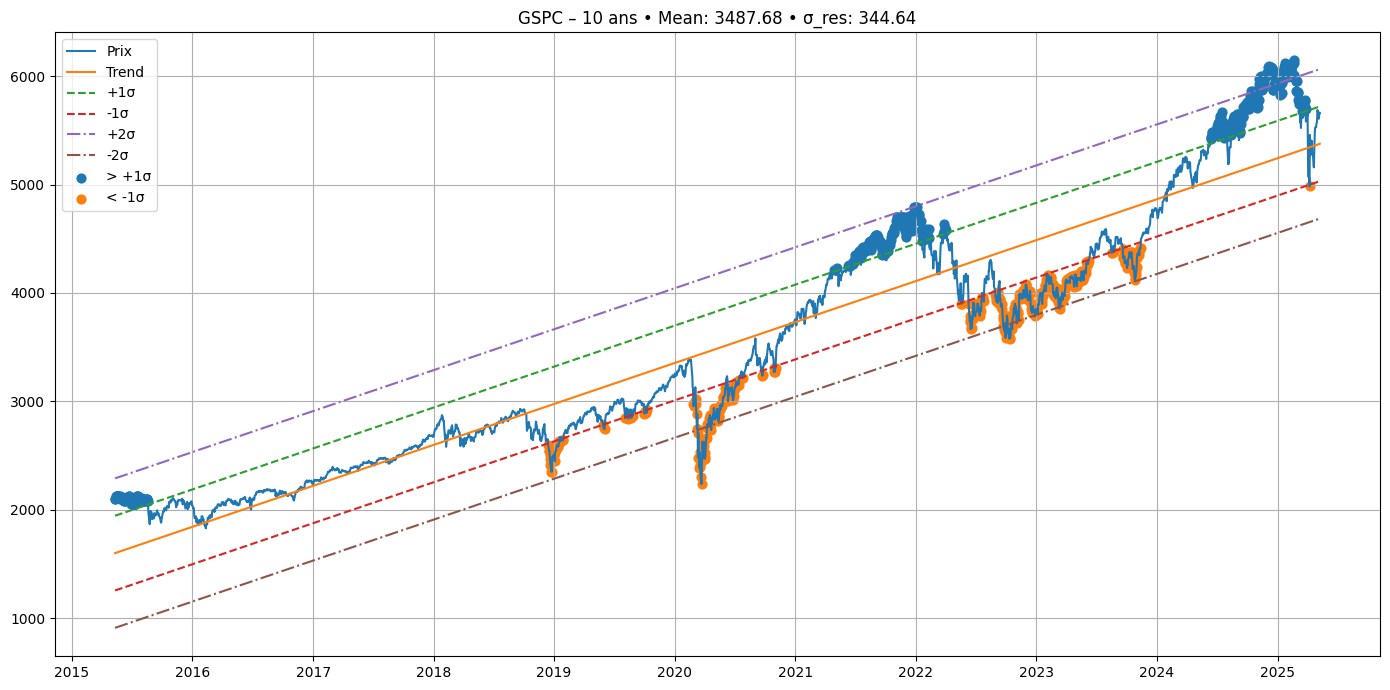

In [19]:
start_10y = (pd.to_datetime(end_date) - pd.DateOffset(years=10)).strftime('%Y-%m-%d')
data_10y  = get_daily_data(ticker_eod, start_10y, end_date, api_token)\
               .resample('B').last().ffill()
plot_with_quantification(data_10y, 'GSPC – 10 ans')


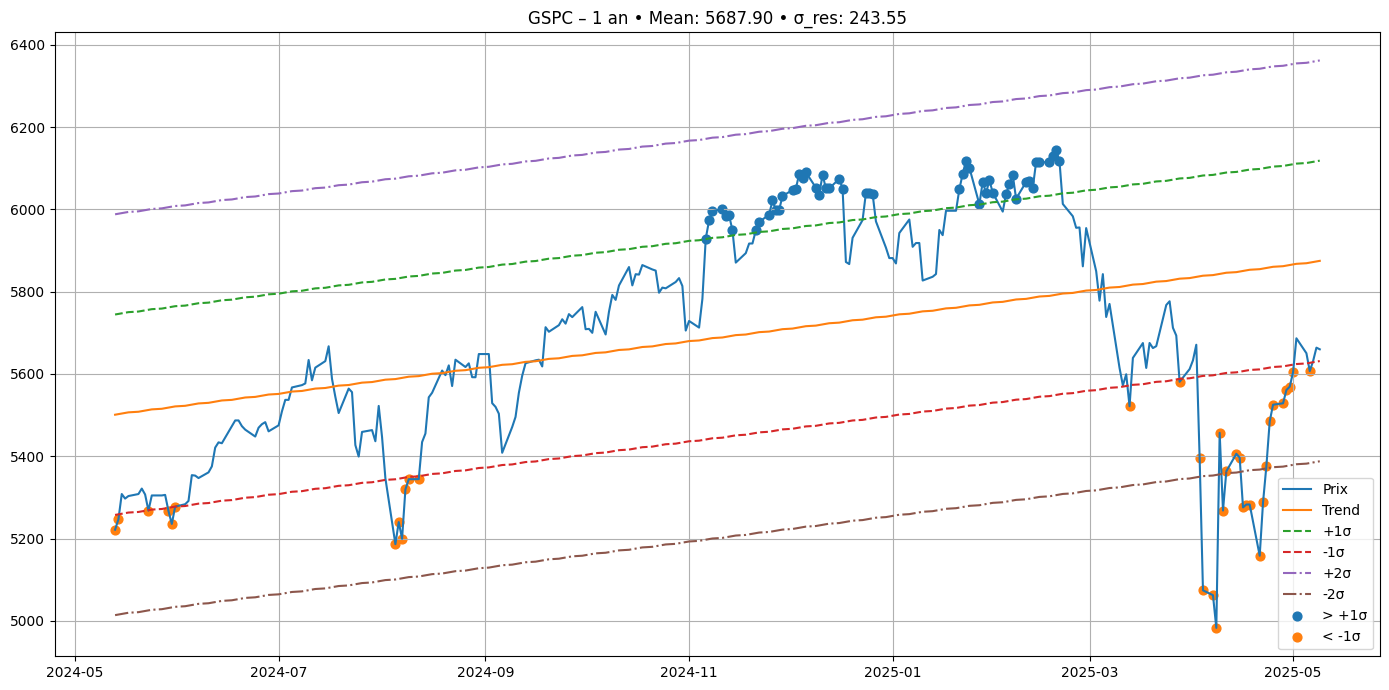

In [20]:
start_1y = (pd.to_datetime(end_date) - pd.DateOffset(years=1)).strftime('%Y-%m-%d')
data_1y  = get_daily_data(ticker_eod, start_1y, end_date, api_token)\
               .resample('B').last().ffill()
plot_with_quantification(data_1y, 'GSPC – 1 an')

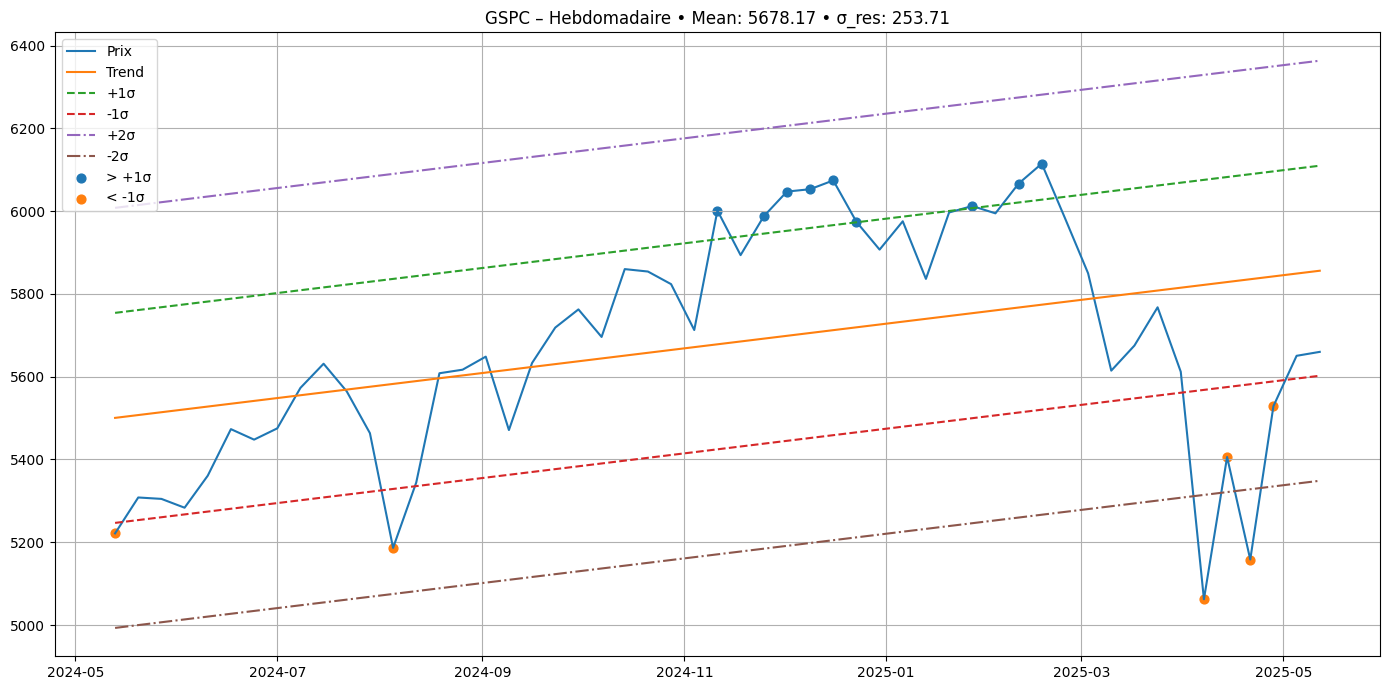

In [21]:
start_weekly = (pd.to_datetime(end_date) - pd.DateOffset(years=1)).strftime('%Y-%m-%d')
data_weekly  = get_daily_data(ticker_eod, start_weekly, end_date, api_token)\
                   .resample('W-MON').last().ffill()
plot_with_quantification(data_weekly, 'GSPC – Hebdomadaire')


=== ANALYSE JOURNALIÈRE (1 MOIS) ===

Prob_upper: 8.0000
Prob_lower: 8.0000
Mean_upper_excess: 0.3149
Max_upper_excess: 0.5578
Mean_lower_excess: 0.3523
Max_lower_excess: 0.4102
Evt_threshold: 5770.5021
Asymmetry: 0.0374
Var: -0.0195
ret_mean: 0.1894
ret_std: 1.0785
var_hist: -1.9465
es_hist: -2.2988
homeostasis: 0.0166
feedback: 0.3333
regime_variety: nan
tail_grad_upper: 0.0000
tail_grad_lower: -0.0500
mimetic_tension: 0.0000
dynamic_homeostasis: -0.4465
quantum_collapse: 0.0993
fractal_queue_memory: 0.0671
adaptive_prob_upper: 0.0500
adaptive_prob_lower: 0.0500
reversion_index: 0.7629


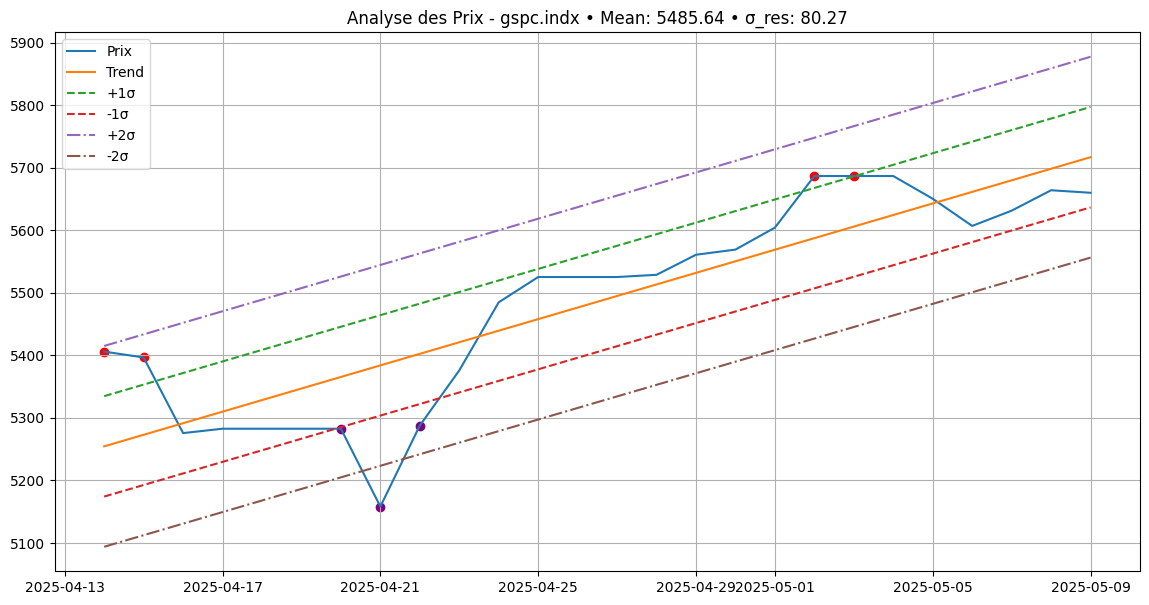

In [5]:
import pandas as pd
import numpy as np
import requests
from scipy.stats import genpareto, kurtosis, skew
from arch import arch_model
import matplotlib.pyplot as plt
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from sklearn.linear_model import LinearRegression
import warnings

def tail_energy_gradient(returns, window=5, alpha=0.05):
    upper_tail = returns > returns.quantile(1 - alpha)
    lower_tail = returns < returns.quantile(alpha)
    grad_upper = upper_tail.rolling(window).sum().diff()
    grad_lower = lower_tail.rolling(window).sum().diff()
    return grad_upper.mean(), grad_lower.mean()

def mimetic_tension(returns, window=5):
    pos_ratio = (returns > 0).rolling(window).mean()
    neg_ratio = (returns < 0).rolling(window).mean()
    feedback = pos_ratio - neg_ratio
    return feedback.diff().mean()

def dynamic_homeostasis(returns, window=10):
    rolling_mean = returns.rolling(window).mean()
    rolling_std = returns.rolling(window).std()
    ratio = rolling_std / rolling_mean
    return ratio.diff().mean()

def quantum_collapse(markov_results):
    p = markov_results.smoothed_marginal_probabilities
    diff = p.diff().abs()
    return diff.mean().mean()

def fractal_queue_memory(returns, alpha=0.05, lag=10):
    excess = (returns < returns.quantile(alpha)) | (returns > returns.quantile(1 - alpha))
    autocorrs = [excess.autocorr(lag=i) for i in range(1, lag+1)]
    return np.nanmean(autocorrs)

def adaptive_tail_probabilities(returns, window=20, alpha=0.05):
    local_probs = []
    for i in range(window, len(returns)):
        sub = returns[i-window:i]
        upper_q = sub.quantile(1 - alpha)
        lower_q = sub.quantile(alpha)
        local_probs.append(((sub > upper_q).mean(), (sub < lower_q).mean()))
    upper_prob, lower_prob = np.nanmean(local_probs, axis=0)
    return upper_prob, lower_prob

def reversion_index(metrics):
    comps = [
        abs(metrics.get("tail_grad_upper", 0)),
        abs(metrics.get("tail_grad_lower", 0)),
        abs(metrics.get("mimetic_tension", 0)),
        abs(metrics.get("dynamic_homeostasis", 0)),
        abs(metrics.get("quantum_collapse", 0)),
        abs(metrics.get("fractal_queue_memory", 0)),
        metrics.get("adaptive_prob_upper", 0),
        metrics.get("adaptive_prob_lower", 0),
    ]
    return np.nansum(comps)

def full_tail_reversion_analysis(data, markov_results):
    returns = data['close'].pct_change().dropna() * 100
    m = {}
    gu, gl = tail_energy_gradient(returns)
    m["tail_grad_upper"], m["tail_grad_lower"] = gu, gl
    m["mimetic_tension"]      = mimetic_tension(returns)
    m["dynamic_homeostasis"]  = dynamic_homeostasis(returns)
    m["quantum_collapse"]     = quantum_collapse(markov_results)
    m["fractal_queue_memory"] = fractal_queue_memory(returns)
    up, lp = adaptive_tail_probabilities(returns)
    m["adaptive_prob_upper"], m["adaptive_prob_lower"] = up, lp
    m["reversion_index"]      = reversion_index(m)
    return m

def get_daily_data(symbol, start_date, end_date, api_token):
    url = f'https://eodhd.com/api/eod/{symbol}?api_token={api_token}&from={start_date}&to={end_date}&fmt=json'
    r = requests.get(url)
    if r.status_code == 200:
        df = pd.DataFrame(r.json())
        df['datetime'] = pd.to_datetime(df['date'])
        df = df.set_index('datetime').sort_index().asfreq('D', method='ffill')
        return df[['close']].ffill().bfill()
    return pd.DataFrame()

def calculate_evt_metrics(returns_percent, last_close, alpha=0.05):
    if len(returns_percent) < 10:
        keys = ['Prob_upper','Prob_lower','Mean_upper_excess','Max_upper_excess',
                'Mean_lower_excess','Max_lower_excess','Evt_threshold','Asymmetry','Var']
        return {k: np.nan for k in keys}
    upper = np.percentile(returns_percent, 100*(1-alpha))
    lower = np.percentile(returns_percent, 100*alpha)
    eu = returns_percent[returns_percent>upper] - upper
    el = lower - returns_percent[returns_percent<lower]
    return {
        'Prob_upper': (returns_percent>upper).mean()*100,
        'Prob_lower': (returns_percent<lower).mean()*100,
        'Mean_upper_excess': eu.mean() if len(eu)>0 else 0,
        'Max_upper_excess': eu.max()  if len(eu)>0 else 0,
        'Mean_lower_excess': el.mean() if len(el)>0 else 0,
        'Max_lower_excess': el.max()  if len(el)>0 else 0,
        'Evt_threshold': last_close*(1+upper/100),
        'Asymmetry': el.mean() - eu.mean(),
        'Var': lower/100
    }

def calculate_metrics(data):
    res = {}
    r = data.close.pct_change().dropna()
    rp = r * 100
    if not r.empty:
        last = data.close.iloc[-1]
        res.update(calculate_evt_metrics(rp, last))
        res['ret_mean'] = r.mean()*100
        res['ret_std']  = r.std()*100
    else:
        keys = ['Prob_upper','Prob_lower','Mean_upper_excess','Max_upper_excess',
                'Mean_lower_excess','Max_lower_excess','Evt_threshold','Asymmetry','Var',
                'ret_mean','ret_std']
        res.update({k: np.nan for k in keys})
    return res

def calculate_risk_metrics(data, alpha=0.05):
    r = data.close.pct_change().dropna()
    if r.empty:
        return np.nan, np.nan
    v  = np.percentile(r, alpha*100)
    es = r[r<=v].mean()
    return v, es

class SystemicAnalyzer:
    def __init__(self, data):
        self.data = data
    def ashby_homeostasis(self, window=10):
        m = self.data.close.rolling(window).mean()
        s = self.data.close.rolling(window).std()
        return (s/m).mean()
    def bateson_feedback(self, window=5):
        r  = self.data.close.pct_change().dropna()
        pr = (r>0).rolling(window).mean()
        nr = (r<0).rolling(window).mean()
        return (pr - nr).mean()
    def requisite_variety(self, n_regimes=2):
        try:
            ds = self.data.close.diff().dropna()
            if len(ds)<50: return np.nan
            mdl = MarkovRegression(ds, k_regimes=n_regimes)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                res = mdl.fit(disp=False)
            return res.smoothed_marginal_probabilities.std().mean()
        except:
            return np.nan
    def analyze_systemics(self):
        return {
            'homeostasis':    self.ashby_homeostasis(),
            'feedback':       self.bateson_feedback(),
            'regime_variety': self.requisite_variety()
        }

def plot_with_quantification(data, title):
    df = data.copy().reset_index()
    df['day_num'] = np.arange(len(df))
    X, y = df[['day_num']].values, df['close'].values
    m = LinearRegression().fit(X, y)
    df['trend'] = m.predict(X)
    res     = y - df['trend']
    std_res = res.std()
    mean_p  = df['close'].mean()
    df['in_upper'] = df['close'] > (df['trend'] + 1*std_res)
    df['in_lower'] = df['close'] < (df['trend'] - 1*std_res)
    plt.figure(figsize=(14,7))
    plt.plot(df['datetime'], df['close'], label='Prix')
    plt.plot(df['datetime'], df['trend'], label='Trend')
    plt.plot(df['datetime'], df['trend'] + std_res,  linestyle='--', label='+1σ')
    plt.plot(df['datetime'], df['trend'] - std_res,  linestyle='--', label='-1σ')
    plt.plot(df['datetime'], df['trend'] + 2*std_res, linestyle='-.', label='+2σ')
    plt.plot(df['datetime'], df['trend'] - 2*std_res, linestyle='-.', label='-2σ')
    plt.scatter(df.loc[df['in_upper'],'datetime'], df.loc[df['in_upper'],'close'], c='red')
    plt.scatter(df.loc[df['in_lower'],'datetime'], df.loc[df['in_lower'],'close'], c='purple')
    plt.title(f"{title} • Mean: {mean_p:.2f} • σ_res: {std_res:.2f}")
    plt.legend(); plt.grid(True); plt.show()

api_token  = '680c2589504568.26159307'
ticker     = 'gspc.indx'
end_date   = pd.to_datetime('today').strftime('%Y-%m-%d')
start_date = (pd.to_datetime('today') - pd.DateOffset(months=1)).strftime('%Y-%m-%d')

data = get_daily_data(ticker, start_date, end_date, api_token)
if data.empty:
    print("Erreur de récupération des données")
else:
    data_clean = data.dropna(subset=['close'])
    if data_clean.empty:
        print("Données insuffisantes après nettoyage")
    else:
        metrics = calculate_metrics(data_clean)
        v, es = calculate_risk_metrics(data_clean, alpha=0.05)
        metrics['var_hist'], metrics['es_hist'] = v*100, es*100
        sys = SystemicAnalyzer(data_clean)
        metrics.update(sys.analyze_systemics())
        try:
            ds  = data_clean.close.diff().dropna()
            mdl = MarkovRegression(ds, k_regimes=2)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                markov_results = mdl.fit(disp=False)
        except Exception as e:
            print("Erreur Markov:", e)
            markov_results = None
        if markov_results is not None:
            metrics.update(full_tail_reversion_analysis(data_clean, markov_results))
        print("\n=== ANALYSE JOURNALIÈRE (1 MOIS) ===\n")
        for k, v in metrics.items():
            print(f"{k}: {v:.4f}" if isinstance(v, (int, float)) else f"{k}: {v}")
        plot_with_quantification(data_clean, f"Analyse des Prix - {ticker}")
